# Reinforcement Learning

In [1]:
import game2048_env
import numpy as np
import random
# fixing seed for reproducibility
random.seed(0)
np.random.seed(0)
import matplotlib.pyplot as plt
import PIL.Image as Image
import warnings
import math
warnings.simplefilter('ignore')
%matplotlib inline
import seaborn as sns

sns.set()
from IPython.display import clear_output

## Q-learning?
To calculate the total q table, all possible states must be calculated. This is done by multiplying the board size with the board size. And, then calculating each possible tile (if we limit the game to reach 2048). Starting from 2 until 2048, there are 11 unique tiles: 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048. And, ofcourse, there is a blank cell. The final equation would be total_states = unique_tiles ^ total_cells_on_board

In [2]:
total_cells_on_board = 4 * 4
unique_tiles = 11
assert 2048 == 2 ** unique_tiles, f"2048 does not have {unique_tiles} powers"
unique_tiles += 1
total_states = unique_tiles ** total_cells_on_board
print(f'Total states: {total_states:,}')

Total states: 184,884,258,895,036,416


Considering that the Q-table would be too large. A switch to an ANN model is not a bad idea.

## TensorFlow


In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy

In [4]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from collections import deque

class DQN:
    def __init__(self, env):
        self.env = env
        self.memory = deque(maxlen=2_000_000) #

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.01
        self.tau = 0.05

        self.model = self.create_model()
        self.target_model = self.create_model()

    def create_model(self):
        state_shape = self.env.observation_space.shape

        inputs = Input(16)
        x = Dense(units=24, activation='relu')(inputs)
        x = Dense(units=48, activation='relu')(x)
        x = Dense(units=48, activation='relu')(x)
        outputs = Dense(units=self.env.action_space.n, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model 

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size = 32
        if len(self.memory) < batch_size:
            return
        
        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            new_state = np.expand_dims(new_state.flatten(), axis=0)
            state = np.expand_dims(state.flatten(), axis=0)
            # print(f'samples: {new_state.shape}')
            target = self.target_model.predict(state)
            # print(f'target:', target)
            if done:
                target[0][action] = reward
            else:
                predicted = self.target_model.predict(new_state)
                # print(predicted)
                Q_future = max(predicted[0])
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        # target_weights = self.target_model.get_weights()
        # for i in range(len(target_weights)):
        #     target_weights[i] = weights[i]
        self.target_model.set_weights(weights)
    
    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = np.expand_dims(state.flatten(), axis=0)
        predicted = self.model.predict(state)
        # print(f'predicted act: {predicted}')
        return np.argmax(predicted[0])

In [5]:
def render_env(env, output_text):
    clear_output(wait=True)
    print(output_text)
    rgb = env.render('rgb_array')
    display(Image.fromarray(rgb))

Trial: 26, score: 4.0, highest tile: 4


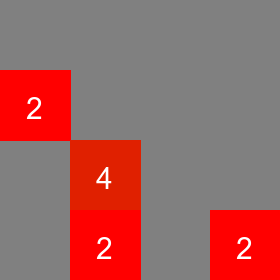

In [6]:
env = game2048_env.Game2048Env()
env.seed(42)
env.set_max_tile(2048)
gamma = 0.9
epsilon = 0.95

trials_num = 100
trials_len = 1000
directions = ["Up", "Right", "Down", "Left"]

dqn_agent = DQN(env=env)
trials = []
scores = []
highest_tiles = []
output_text = ''
for trial in range(trials_num):
    current_state = env.reset()
    for step in range(trials_len):
        render_env(env, output_text)
        action = dqn_agent.act(current_state)
        # print(directions[action])
        # print(current_state)
        new_state, reward, done, info = env.step(action)
        # print(new_state)
        reward = reward if not done else -20
        # reward = reward if not info['illegal_move'] else -20
        dqn_agent.remember(current_state, action, reward, new_state, done)
        
        dqn_agent.replay()
        dqn_agent.target_train()

        current_state = new_state

        # if info['illegal_move']:
        #     continue

        if done:
            print(step)
            break
    highest = env.highest()
    scores.append(env.score)
    highest_tiles.append(highest)
    trials.append(trial)
    output_text = f"Trial: {trial}, score: {env.score}, highest tile: {highest}"
    if env.highest() == env.max_tile:
        break

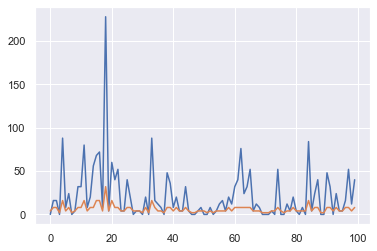

In [8]:
plt.plot(trials, scores)
plt.plot(trials, highest_tiles)